# Hello, FABRIC: Create your first FABRIC slice

## Configure the Environment

Set the environment variable that will be used by this notebook. If you are using the FABRIC, JupyterHub some of the environment will be automatically configured for you.  You will only need to set your bastion username, upload your bastion private key, and set the path to where you put your bastion private key. Your bastion username and private key should already be in your possession.  If you do not have a bastion username and private key, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

If you are using the FABRIC API outside of the JupyterHub you will need to configure all of the environment variables. Defaults below will be correct in many situations but you will need to confirm your configuration.  If you have questions about this configuration, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

More information about accessing your experiments through the FABRIC bastion hosts can be found [here](https://learn.fabric-testbed.net/knowledge-base/logging-into-fabric-vms/).

In [1]:
import os

# If you are using the FABRIC JupyterHub, the following three evnrionment vars
# were automatically provided when you logged in.
#os.environ['FABRIC_CREDMGR_HOST']='cm.fabric-testbed.net'
#os.environ['FABRIC_ORCHESTRATOR_HOST']='orchestrator.fabric-testbed.net'
#os.environ['FABRIC_TOKEN_LOCATION']=os.environ['HOME']+'/work/fabric_token_beta.json'

# Bastion IPs
os.environ['FABRIC_BASTION_HOST'] = 'bastion-1.fabric-testbed.net'

# Set your Bastion username and private key
os.environ['FABRIC_BASTION_USERNAME']='pruth_0031379841'
os.environ['FABRIC_BASTION_KEY_LOCATION']=os.environ['HOME']+'/FABRIC/pruth-bastion-1'

# Set the keypair FABRIC will install in your slice. 
os.environ['FABRIC_SLICE_PRIVATE_KEY_FILE']=os.environ['HOME']+'/.ssh/id_rsa'
os.environ['FABRIC_SLICE_PUBLIC_KEY_FILE']=os.environ['HOME']+'/.ssh/id_rsa.pub'

# If your slice private key uses a passphrase, set the passphrase
#from getpass import getpass
#print('Please input private key passphrase. Press enter for no passphrase.')
#os.environ['FABRIC_SLICE_PRIVATE_KEY_PASSPHRASE']=getpass()

## Setup the Experiment

#### Import the FABRIC API

In [2]:
import json
import traceback
from fabrictestbed_extensions.fablib.fablib import fablib

#### Create the FABRIC Proxies

The FABRIC API is used via proxy objects that manage connections to the control framework.  

#### (Optional) Query Available Resources

This optional command queries the FABRIC services to find the available resources. It may be useful for finding a site with available capacity.

Available Resources: RENC [Site] : { cpu: 6/6 , core: 188/192 , ram: 1,524/1,536 G, disk: 60,580/60,600 G, unit: 3/3 }
	Components:
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 9/10 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 0/2 }
	Site Interfaces:
		RENC_UKY: TrunkPort { bw: 10/10 Gbps}
		RENC_LBNL: TrunkPort { bw: 10/10 Gbps}
LBNL [Site] : { cpu: 6/6 , core: 182/192 , ram: 1,496/1,536 G, disk: 60,550/60,600 G, unit: 3/3 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
		NVME-P4510:  NVME P4510 { disk: 10,000/10,000 G, unit: 10/10 }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2

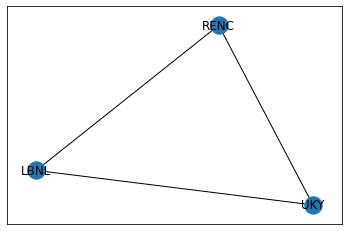

In [3]:
try:
    available_resources = fablib.get_available_resources()
    print(f"Available Resources: {available_resources}")
    available_resources.draw()
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

## Create the Experiment Slice

#### Configure the Experiment Parameters



In [4]:
slice_name_base = 'MySlice'
#sites = [ 'UKY', 'RENC', 'LBNL' ]
sites = [ 'UKY', 'LBNL' ]

#workers = [ 'uky-w1', 'uky-w2', 'uky-w3', 'renc-w1',  'renc-w1', 'renc-w2', 'lbnl-w3', 'lbnl-w2', 'lbnl-w3' ]
node_name_base = 'node'
image = 'default_centos_8'
cores = 2
ram = 8
disk = 10

node_count=5

tests = {}
for site in sites:
    workers = []
    for worker_num in range(1,4):
        workers.append(f"{site.lower()}-w{worker_num}.fabric-testbed.net")
    tests[site] = workers

print(f"{tests}")

{'UKY': ['uky-w1.fabric-testbed.net', 'uky-w2.fabric-testbed.net', 'uky-w3.fabric-testbed.net'], 'LBNL': ['lbnl-w1.fabric-testbed.net', 'lbnl-w2.fabric-testbed.net', 'lbnl-w3.fabric-testbed.net']}


### Create Slice

<img src="./figs/SingleNode.png" width="20%"><br>

Create a single node with basic compute capabilities. The submit function will block until the node is ready and will display a progress bar.


In [5]:
for site,workers in tests.items():
    for worker in workers:
        try:
            slice_name=f"{slice_name_base}_{worker}"
            print(f"Creating slice {slice_name} on worker {worker}")
            #Create Slice
            slice = fablib.new_slice(slice_name)

            for node_num in range(node_count):
                node_name = f"{node_name_base}{node_num}"
                # Add node
                node = slice.add_node(name=node_name, site=site)
                node.set_capacities(cores=cores, ram=ram, disk=disk)
                node.set_image(image)
                node.set_host(worker)

            #Submit Slice Request
            slice.submit(wait_progress=False)
        except Exception as e:
            print(f"Slice Failed: {e}")
            #traceback.print_exc()
        
        

Creating slice MySlice_uky-w1.fabric-testbed.net on worker uky-w1.fabric-testbed.net
Creating slice MySlice_uky-w2.fabric-testbed.net on worker uky-w2.fabric-testbed.net
Creating slice MySlice_uky-w3.fabric-testbed.net on worker uky-w3.fabric-testbed.net
Creating slice MySlice_lbnl-w1.fabric-testbed.net on worker lbnl-w1.fabric-testbed.net
Creating slice MySlice_lbnl-w2.fabric-testbed.net on worker lbnl-w2.fabric-testbed.net
Creating slice MySlice_lbnl-w3.fabric-testbed.net on worker lbnl-w3.fabric-testbed.net


In [6]:
for site,workers in tests.items():
    for worker in workers:
        try:
            slice_name=f"{slice_name_base}_{worker}"
            print(f"Waiting for slice {slice_name} at {worker}")

            #Get Slice
            slice = fablib.get_slice(slice_name)
            
            #Wait for ssh to be active
            slice.wait_ssh(progress=True)
            
            #Run post boo config
            slice.post_boot_config(verbose=True)
        except Exception as e:
            print(f"Slice Failed: {e}")
            #traceback.print_exc()

Waiting for slice MySlice_uky-w1.fabric-testbed.net at uky-w1.fabric-testbed.net
Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful
Waiting for slice MySlice_uky-w2.fabric-testbed.net at uky-w2.fabric-testbed.net
Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful
Waiting for slice MySlice_uky-w3.fabric-testbed.net at uky-w3.fabric-testbed.net
Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful
Waiting for slice MySlice_lbnl-w1.fabric-testbed.net at lbnl-w1.fabric-testbed.net
Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful
Waiting for slice MySlice_lbnl-w2.fabric-testbed.net at lbnl-w2.fabric-testbed.net
Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful
Waiting for slice MySlice_lbnl-w3.fabric-testbed.net at lbnl-w3.fabric-testbed.net
Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


### Get the New Slice

Your new slice is in the list of all your slices. You can get the specific slice using the fablib library.

In [ ]:
for site,workers in tests.items():
    for worker in workers:
        try:
            slice_name=f"{slice_name_base}_{worker}"
            print(f"Getting {slice_name} slice at {site}")

            slice = fablib.get_slice(slice_name)
            print(f"Slice: {slice.get_name()}, {slice.get_state()}")
        except Exception as e:
            print(f"Get Slices Fail: {e}")

### Print the Node's Attributes

Each node in the slice has a set of get functions that return the node's attributes.

In [8]:
for site,workers in tests.items():
    for worker in workers:
        try:
            slice_name=f"{slice_name_base}_{worker}"
            print(f"Get attributes for {slice_name} at {site}")    
            slice = fablib.get_slice(slice_name)
            for node in slice.get_nodes():
                print("Node:")
                print(f"   Name              : {node.get_name()}")
                print(f"   Cores             : {node.get_cores()}")
                print(f"   RAM               : {node.get_ram()}")
                print(f"   Disk              : {node.get_disk()}")
                print(f"   Image             : {node.get_image()}")
                print(f"   Image Type        : {node.get_image_type()}")
                print(f"   Host              : {node.get_host()}")
                print(f"   Site              : {node.get_site()}")
                print(f"   Management IP     : {node.get_management_ip()}")
                print(f"   Reservation ID    : {node.get_reservation_id()}")
                print(f"   Reservation State : {node.get_reservation_state()}")
                print(f"   Components        : {node.get_components()}")
                print(f"   Interfaces        : {node.get_interfaces()}")
                print(f"   SSH Command       : {node.get_ssh_command()}")
                print()    
        except Exception as e:
            print(f"Fail: {e}")

Get attributes for MySlice_uky-w1.fabric-testbed.net at UKY
Failure: (504)
Reason: Gateway Time-out
HTTP response headers: HTTPHeaderDict({'Server': 'nginx/1.19.8', 'Date': 'Wed, 23 Feb 2022 15:20:21 GMT', 'Content-Type': 'text/html', 'Content-Length': '167', 'Connection': 'keep-alive'})
HTTP response body: <html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
<hr><center>nginx/1.19.8</center>
</body>
</html>


Fail: Slice MySlice_uky-w1.fabric-testbed.net not found
Get attributes for MySlice_uky-w2.fabric-testbed.net at UKY
Failure: (504)
Reason: Gateway Time-out
HTTP response headers: HTTPHeaderDict({'Server': 'nginx/1.19.8', 'Date': 'Wed, 23 Feb 2022 15:21:21 GMT', 'Content-Type': 'text/html', 'Content-Length': '167', 'Connection': 'keep-alive'})
HTTP response body: <html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
<hr><center>nginx/1.19.8</center>
</body>
</html>


Fa

## Accessing the VM


#### SSH with fablib

Most experiments will require automated configuration and execution. You can use the fablib library to execute arbitrary commands on your node. 

The following code demonstrates how to use fablib to execute a "Hello, FABRIC" bash script. The library uses the bastion and VM keys defined at the top of this notebook to jump through the bastion host and execute the script.

In [9]:
command= 'echo Hello, FABRIC from node `hostname -s`'

In [ ]:
for site,workers in tests.items():
    for worker in workers:
        try:
            slice_name=f"{slice_name_base}_{worker}"
            print(f"Executing command for {slice_name} at {site}")    
            slice = fablib.get_slice(slice_name)
            for node in slice.get_nodes():
                stdout, stderr = node.execute(command)
                print(stdout)
        except Exception as e:
            print(f"Fail: {e}")

Executing command for MySlice_uky-w1.fabric-testbed.net at UKY


## Delete Slice

Please delete your slicd when you are done with your experiment.

In [ ]:
for site,workers in tests.items():
    for worker in workers:
        try:
            slice_name=f"{slice_name_base}_{worker}"

            print(f"Deleting for {slice_name} at {site}")    
            slice = fablib.get_slice(slice_name)
            slice.delete()
        except Exception as e:
            print(f"Fail: {e}")